In [1]:
# ========================= Importar Librerias ======================================

import matplotlib.pyplot as plt
import thejoker.units as xu
import scipy.stats as stats
import astropy.units as u
import statistics as stat
import seaborn as sns
import thejoker as tj
import pandas as pd
import numpy as np
import arviz as az
import pymc as pm
import warnings
warnings.filterwarnings('ignore')
import inspect
import corner
import math 
import h5py
import os


from astropy.visualization.units import quantity_support
from sklearn.metrics import mean_squared_error
from thejoker import JokerPrior, TheJoker, RVData
from thejoker.plot import plot_rv_curves
from scipy.stats import gaussian_kde
from os.path import join
from tqdm import tqdm

In [2]:
# ========================= Definición de Funciones ======================================
def seleccionar_distribuciones(familia='realall', verbose=True):
    '''
    Esta función selecciona un subconjunto de las distribuciones disponibles
    en scipy.stats
    
    Parameters
    ----------
    familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
        realall: distribuciones de la familia `realline` + `realplus`
        realline: distribuciones continuas en el dominio (-inf, +inf)
        realplus: distribuciones continuas en el dominio [0, +inf)
        real0to1: distribuciones continuas en el dominio [0,1]
        discreta: distribuciones discretas
        
    verbose : bool
        Si se muestra información de las distribuciones seleccionadas
        (the default `True`).
        
    Returns
    -------
    distribuciones: list
        listado con las distribuciones (los objetos) seleccionados.
        
    Raises
    ------
    Exception
        Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
        o 'discreta'.
        
    Notes
    -----
        Las distribuciones levy_stable y vonmises han sido excluidas por el momento.

    '''
    
    distribuciones = [getattr(stats,d) for d in dir(stats) \
                     if isinstance(getattr(stats,d), (stats.rv_continuous, stats.rv_discrete))]
    
    exclusiones = ['levy_stable', 'vonmises']
    distribuciones = [dist for dist in distribuciones if dist.name not in exclusiones]
            
    dominios = {
        'realall' : [-np.inf, np.inf],
        'realline': [np.inf,np.inf],
        'realplus': [0, np.inf],
        'real0to1': [0, 1], 
        'discreta': [None, None],
    }

    distribucion = []
    tipo = []
    dominio_inf = []
    dominio_sup = []

    for dist in distribuciones:
        distribucion.append(dist.name)
        tipo.append(np.where(isinstance(dist, stats.rv_continuous), 'continua', 'discreta'))
        dominio_inf.append(dist.a)
        dominio_sup.append(dist.b)
    
    info_distribuciones = pd.DataFrame({
                            'distribucion': distribucion,
                            'tipo': tipo,
                            'dominio_inf': dominio_inf,
                            'dominio_sup': dominio_sup
                          })

    info_distribuciones = info_distribuciones \
                          .sort_values(by=['dominio_inf', 'dominio_sup'])\
                          .reset_index(drop=True)
    
    if familia in ['realall', 'realline', 'realplus', 'real0to1']:
        info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='continua']
        condicion = (info_distribuciones['dominio_inf'] == dominios[familia][0]) & \
                    (info_distribuciones['dominio_sup'] == dominios[familia][1]) 
        info_distribuciones = info_distribuciones[condicion].reset_index(drop=True)
        
    if familia in ['discreta']:
        info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='discreta']
        
    seleccion = [dist for dist in distribuciones \
                 if dist.name in info_distribuciones['distribucion'].values]
    
    
    if verbose:
        print("---------------------------------------------------")
        print("       Distribuciones seleccionadas                ")
        print("---------------------------------------------------")
        with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
            print(info_distribuciones)
    
    return seleccion


def comparar_distribuciones(x, familia='realall', ordenar='aic', verbose=True):
    '''
    Esta función selecciona y ajusta un subconjunto de las distribuciones 
    disponibles en scipy.stats. Para cada distribución calcula los valores de
    Log Likelihood, AIC y BIC.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
        realall: distribuciones de la familia `realline` + `realplus`
        realline: distribuciones continuas en el dominio (-inf, +inf)
        realplus: distribuciones continuas en el dominio [0, +inf)
        real0to1: distribuciones continuas en el dominio [0,1]
        discreta: distribuciones discretas
    
    ordenar : {'aic', 'bic'}
        criterio de ordenación de mejor a peor ajuste.
    
    verbose : bool
        Si se muestra información de las distribuciones seleccionadas
        (the default `True`).
        
    Returns
    -------
    resultados: data.frame
        distribucion: nombre de la distribución.
        log_likelihood: logaritmo del likelihood del ajuste.
        aic: métrica AIC.
        bic: métrica BIC.
        n_parametros: número de parámetros de la distribución de la distribución.
        parametros: parámetros del tras el ajuste
        
    Raises
    ------
    Exception
        Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
        o 'discreta'.
        
    Notes
    -----

    '''
    
    distribuciones = seleccionar_distribuciones(familia=familia, verbose=verbose)
    distribucion_ = []
    log_likelihood_= []
    aic_ = []
    bic_ = []
    n_parametros_ = []
    parametros_ = []
    
    for i, distribucion in enumerate(distribuciones):
        
        print(f"{i+1}/{len(distribuciones)} Ajustando distribución: {distribucion.name}")
        
        try:
            parametros = distribucion.fit(data=x)
            nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                 if not p=='x'] + ["loc","scale"]
            parametros_dict = dict(zip(nombre_parametros, parametros))
            log_likelihood = distribucion.logpdf(x, *parametros).sum()
            aic = -2 * log_likelihood + 2 * len(parametros)
            bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)
            
            distribucion_.append(distribucion.name)
            log_likelihood_.append(log_likelihood)
            aic_.append(aic)
            bic_.append(bic)
            n_parametros_.append(len(parametros))
            parametros_.append(parametros_dict)
            
            resultados = pd.DataFrame({
                            'distribucion': distribucion_,
                            'log_likelihood': log_likelihood_,
                            'aic': aic_,
                            'bic': bic_,
                            'n_parametros': n_parametros_,
                            'parametros': parametros_,
                
                         })
            
            resultados = resultados.sort_values(by=ordenar).reset_index(drop=True)
            
        except Exception as e:
            print(f"Error al tratar de ajustar la distribución {distribucion.name}")
            print(e)
            print("")
            
    return resultados

In [3]:
def plot_distribucion(x, nombre_distribucion, bin, label, unit, ax=None):
    '''
    Esta función superpone la curva de densidad de una distribución con el
    histograma de los datos.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    nombre_distribuciones : str
        nombre de una de las distribuciones disponibles en `scipy.stats`.
        
    Returns
    -------
    resultados: matplotlib.ax
        gráfico creado
        
    Raises
    ------
        
    Notes
    -----
    '''

    distribucion = getattr(stats, nombre_distribucion)

    parametros = distribucion.fit(data=x)

    nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                         if not p=='x'] + ["loc","scale"]
    parametros_dict = dict(zip(nombre_parametros, parametros))

    log_likelihood = distribucion.logpdf(x, *parametros).sum()

    aic = -2 * log_likelihood + 2 * len(parametros)
    bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

    x_hat = np.linspace(min(x), max(x), num=100)
    y_hat = distribucion.pdf(x_hat, *parametros)
    P_max = x_hat[np.argmax(y_hat)]
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))
        
    ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
    ax.hist(x=x, density=True, bins=bin, color="#3182bd", alpha=0.5,edgecolor = '#3F4750');
    ax.plot(x, np.full_like(x, 0), '|k', markeredgewidth=1)
    plt.axvline(P_max, color='#E74C3C', linestyle='--', label=f'Máximo en {label} = {P_max:.5f} {unit}')
    ax.set_title('Ajuste distribución')
    ax.set_xlabel(f'{label} [{unit}]')
    ax.set_ylabel('Densidad de probabilidad')
    ax.legend();

    print('---------------------')
    print('Resultados del ajuste')
    print('---------------------')
    print(f"Distribución:   {distribucion.name}")
    print(f"Dominio:        {[distribucion.a, distribucion.b]}")
    print(f"Parámetros:     {parametros_dict}")
    print(f"Log likelihood: {log_likelihood}")
    print(f"AIC:            {aic}")
    print(f"BIC:            {bic}")
    print(f"{label}_max:          {P_max} {unit}")
    return ax


def plot_multiple_distribuciones(x, nombre_distribuciones, bin, label, unit, ax=None):
    '''
    Esta función superpone las curvas de densidad de varias distribuciones
    con el histograma de los datos.
    
    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.
        
    nombre_distribuciones : list
        lista con nombres de distribuciones disponibles en `scipy.stats`.
        
    Returns
    -------
    resultados: matplotlib.ax
        gráfico creado
        
    Raises
    ------
        
    Notes
    -----
    '''
    aic_list = []
    bic_list = []
    nombres = []
    Best_fit = pd.DataFrame()
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))
        
    ax.hist(x=x, density=True, bins=bin, color="#3182bd", alpha=0.5,edgecolor = '#3F4750')
    ax.plot(x, np.full_like(x, 0), '|k', markeredgewidth=1)
    ax.set_title('Ajuste distribuciones')
    ax.set_xlabel(f'{label} [{unit}]')
    ax.set_ylabel('Densidad de probabilidad')
    
    for nombre in nombre_distribuciones:
        
        distribucion = getattr(stats, nombre)

        parametros = distribucion.fit(data=x)

        nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                             if not p=='x'] + ["loc","scale"]
        parametros_dict = dict(zip(nombre_parametros, parametros))

        log_likelihood = distribucion.logpdf(x, *parametros).sum()

        aic = -2 * log_likelihood + 2 * len(parametros)
        bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)
        aic_list.append(aic)
        bic_list.append(bic)
        nombres.append(distribucion.name)
        
        x_hat = np.linspace(min(x), max(x), num=100)
        y_hat = distribucion.pdf(x_hat, *parametros)
        ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
        
    ax.legend();
    
    Best_fit["Distribución"] = nombres
    Best_fit["AIC"] = aic_list
    Best_fit["BIC"] = bic_list
    Best_fit = Best_fit.sort_values(by='BIC')
    return ax, Best_fit

In [4]:
# Lee el archivo de texto y crea un DataFrame
nombres_columnas = ['Estrella', 'TYC', '2MASS']
data = pd.read_csv('Nombres_de_Estrellas.txt', delimiter=' ', names=nombres_columnas, header=None)  # Si el archivo está tabulado, usa '\t' como separador
data

,Estrella,TYC,2MASS
0,Krich_1,TYC22-591-1,2MASSJ01030596+0434459
1,Krich_2,TYC26-777-1,2MASSJ01194936+0634115
2,Na_rich,TYC6908-1643-1,2MASSJ20320320-2332524
3,Nrich_1,TYC4686-2039-1,2MASSJ01575297-0316508
4,Nrich_2,TYC8517-1671-1,2MASSJ05120630-5913438
5,Nrich_3,TYC244-273-1,2MASSJ10022398+0216045
6,Nrich_4,TYC250-1352-1,2MASSJ10071742+0605101
7,Nrich_5,TYC269-474-1,2MASSJ11173689+0645217
8,Nrich_6,TYC7408-694-1,2MASSJ18461977-3021506
9,Nrich_7,TYC5256-183-1,2MASSJ23513172-0312308


In [5]:
columns = ["Star","Date","RV","err_RV","S/R"]
Estrella = {}
mean = []
range = []
std = []
for i in data["Estrella"]:
    Estrella[i] = pd.read_csv(i+'.dat', delimiter='\t', names=columns, header=None)
    #print(Estrella[i])
    mean.append(np.mean(Estrella[i]["RV"]))
    range.append(np.max(Estrella[i]["RV"])-np.min(Estrella[i]["RV"]))
    std.append(np.std(Estrella[i]["RV"]))

In [6]:
Estrella["s-rich"]

,Star,Date,RV,err_RV,S/R
0,TYC6524-876-1,2.459617e+06,315.6384,0.0130,63
1,TYC6524-876-1,2.459651e+06,315.5357,0.0098,102
2,TYC6524-876-1,2.459657e+06,315.5778,0.0114,102
3,TYC6524-876-1,2.459658e+06,315.5968,0.0136,80
4,TYC6524-876-1,2.459659e+06,315.5781,0.0091,114
5,TYC6524-876-1,2.459662e+06,315.5318,0.0120,80
6,TYC6524-876-1,2.459665e+06,315.5052,0.0102,106
7,TYC6524-876-1,2.459667e+06,315.5417,0.0118,97


<Axes: xlabel='time [BMJD]', ylabel='RV [$\\mathrm{km\\,s^{-1}}$]'>

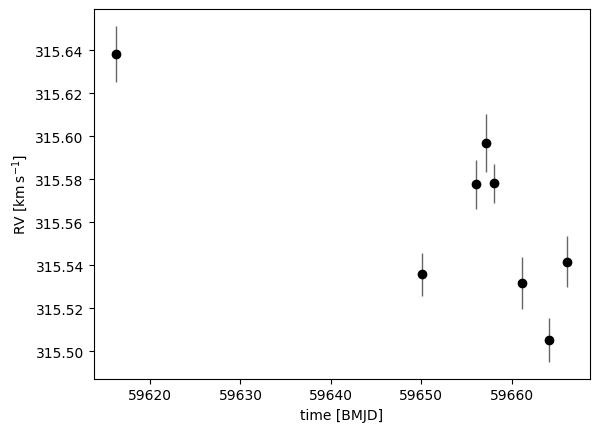

In [7]:
t = np.array(Estrella["s-rich"]["Date"])-2400000.5
rv = np.array(Estrella["s-rich"]["RV"]) * u.km/u.s
err = np.array(Estrella["s-rich"]["err_RV"]) * u.km/u.s
data = tj.RVData(t=t, rv=rv, rv_err=err)
data.plot()

In [8]:
np.std(rv)

<Quantity 0.03998067 km / s>

In [10]:
# data = RVData(t=t, rv=rv, rv_err=err)
# prior = JokerPrior.default(P_min=12.25*u.day, P_max=12.35*u.day,sigma_K0= 30*u.km/u.s,sigma_v=100*u.km/u.s)
# print("Listo")

In [11]:
# with pm.Model() as model:
#     P = xu.with_unit(pm.Normal("P", 762, 5), u.day)
#     K = xu.with_unit(pm.Normal("K", 25, 5), u.km / u.s)
#     prior = tj.JokerPrior.default(sigma_v=50 * u.km / u.s, pars={"P": P,"K" : K})
# joker = TheJoker(prior)

In [12]:
# rng = np.random.default_rng(seed=42) # pequeño retraso en el tiempo 
# prior_samples = prior.sample(size=1_500_000, rng=rng)

# print("Listo")

In [13]:
# prior_samples.write("prior_samples_Nrich7_newdata.hdf5", overwrite=True)

In [14]:
# samples = joker.rejection_sample(data,prior_samples, max_posterior_samples=1000)
# samples = samples.wrap_K()


In [15]:
# samples.write("samples_Nrich7_newdata.hdf5", overwrite=True)

In [9]:
samples = tj.JokerSamples.read("TJ_samples_srich_1.hdf5")
#samples_all = tj.JokerSamples.read("samples_Nrich7_all.hdf5")

samples

<JokerSamples [P, e, omega, M0, s, K, v0] (114 samples)>

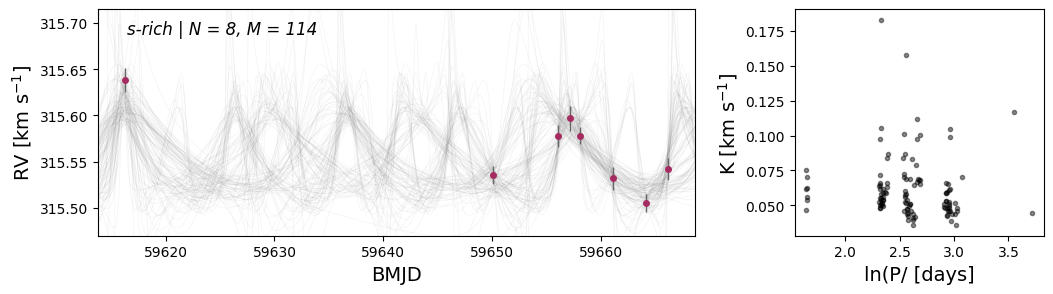

In [11]:
fig = plt.figure(figsize=(22,10))

gs = fig.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.48, wspace=0.4)
f_ax1 = fig.add_subplot(gs[-1, :-1])
f_ax2 = fig.add_subplot(gs[-1,-1])

_ = tj.plot_rv_curves(samples,data=data,plot_kwargs=dict(color="tab:grey"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1)
f_ax2.scatter(np.log(samples['P'].value), samples['K'].value,marker='.', color='k', alpha=0.45)

f_ax1.set_xlabel("BMJD",fontsize=14)
f_ax1.set_ylabel("RV [km s$^{-1}]$", fontsize=14)

f_ax2.set_xlabel("ln(P/ [days]",fontsize=14)
f_ax2.set_ylabel("K [km s$^{-1}]$ ",fontsize=14)

# f_ax1.set_ylim(45,60)
f_ax1.text(0.05, 0.95, f's-rich | N = {len(t)}, M = {len(samples)}', transform=f_ax1.transAxes, fontsize = 12, verticalalignment='top', horizontalalignment='left', fontstyle = 'italic')
plt.show()


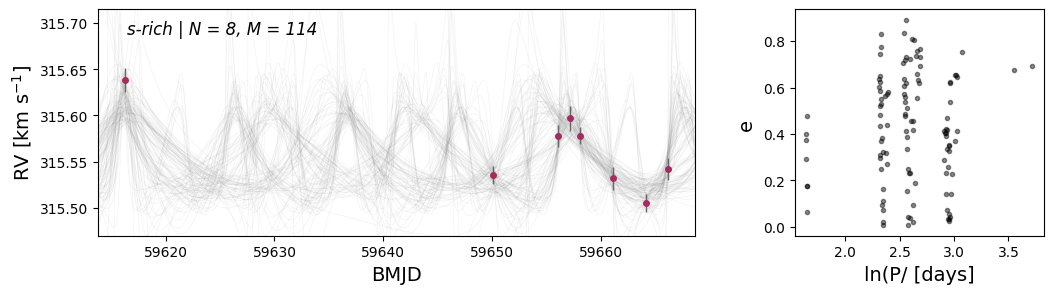

In [13]:
fig = plt.figure(figsize=(22,10))

gs = fig.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.48, wspace=0.4)
f_ax1 = fig.add_subplot(gs[-1, :-1])
f_ax2 = fig.add_subplot(gs[-1,-1])

_ = tj.plot_rv_curves(samples,data=data,plot_kwargs=dict(color="tab:grey"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1)
f_ax2.scatter(np.log(samples['P'].value), samples['e'].value,marker='.', color='k', alpha=0.45)

f_ax1.set_xlabel("BMJD",fontsize=14)
f_ax1.set_ylabel("RV [km s$^{-1}]$", fontsize=14)

f_ax2.set_xlabel("ln(P/ [days]",fontsize=14)
f_ax2.set_ylabel("e ",fontsize=14)

f_ax1.text(0.05, 0.95, f's-rich | N = {len(t)}, M = {len(samples)}', transform=f_ax1.transAxes, fontsize = 12, verticalalignment='top', horizontalalignment='left', fontstyle = 'italic')
plt.show()


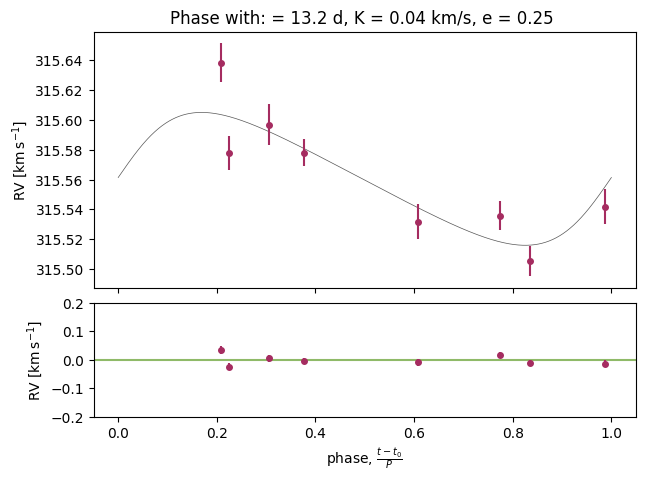

In [14]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 5), gridspec_kw={"height_ratios": (1.8, 0.8), 'hspace': 0.08})

ax[0].set_title(f"Phase with: = {round(float(samples.median_period()['P'].value),2)} d, K = {round(float(samples.median_period()['K'].value),2)} km/s, e = {round(float(samples.median_period()['e'].value),2)} ")

    
_ = tj.plot_phase_fold(samples.median_period(),data=data,ax=ax[0],remove_trend = False,data_plot_kwargs=dict(color="#A52C60"))
_ = tj.plot_phase_fold(samples.median_period(), data, ax=ax[1], residual=True,data_plot_kwargs=dict(color="#A52C60"))

ax[1].axhline(0, zorder=-10, color="#73a942", alpha=0.8)
ax[1].set_ylim(-0.2, 0.2)

for ax in fig.get_axes():
    ax.label_outer()
    #ax.grid(linestyle='-', linewidth=0.1)

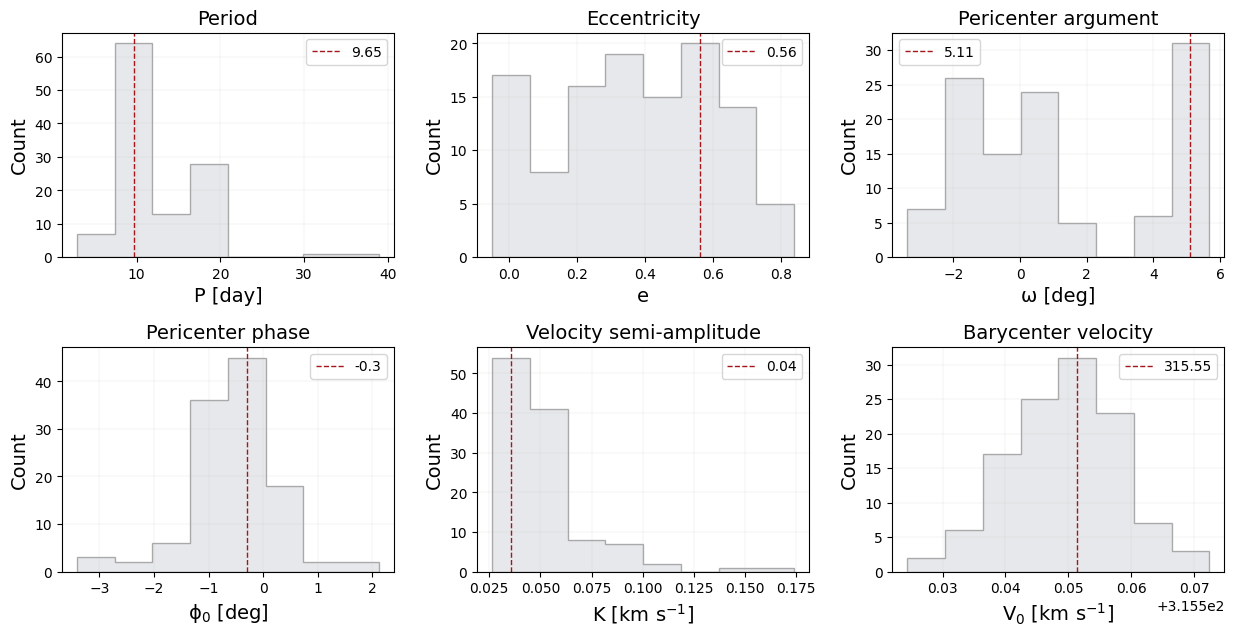

In [15]:
variables = ["P", "e", "omega", "M0", "K", "v0"]
xlabel = ["P [day]", "e", "ω [deg]", "ϕ$_0$ [deg]", "K [km s$^{-1}$]","V$_0$ [km s$^{-1}$]"]
title = ["Period","Eccentricity", "Pericenter argument", "Pericenter phase", "Velocity semi-amplitude", "Barycenter velocity"]
picos = []

fig = plt.figure(figsize=(15,7))

gs = fig.add_gridspec(2, 3, hspace=0.4, wspace=0.25)
(ax1,ax2,ax3), (ax4,ax5,ax6) = gs.subplots(sharey = False, sharex = False)

for ax,i in zip(fig.get_axes(),np.arange(len(variables))):
    ax.set_ylabel("Count", fontsize = 14)
    ax.set_xlabel(xlabel[i], fontsize = 14)
    ax.set_title(title[i], fontsize = 14)
    conteos, bins, _  =  ax.hist(samples[variables[i]], bins = "sturges", histtype='stepfilled', density = False ,alpha=0.3, align = 'left', color = '#adb5bd', ec="k")
    indice_maximo = np.argmax(conteos)
    
    # Obtener el valor del pico más alto
    pico_mas_alto = bins[indice_maximo]
    picos.append(pico_mas_alto)
    # Agregar una línea vertical en el pico más alto
    ax.axvline(x=pico_mas_alto, color='#a4161a', linestyle='--', linewidth = 1, label = f"{round(pico_mas_alto,2)}")
    ax.grid(linestyle='-', linewidth=0.1)
    ax.legend()

<function matplotlib.pyplot.show(close=None, block=None)>

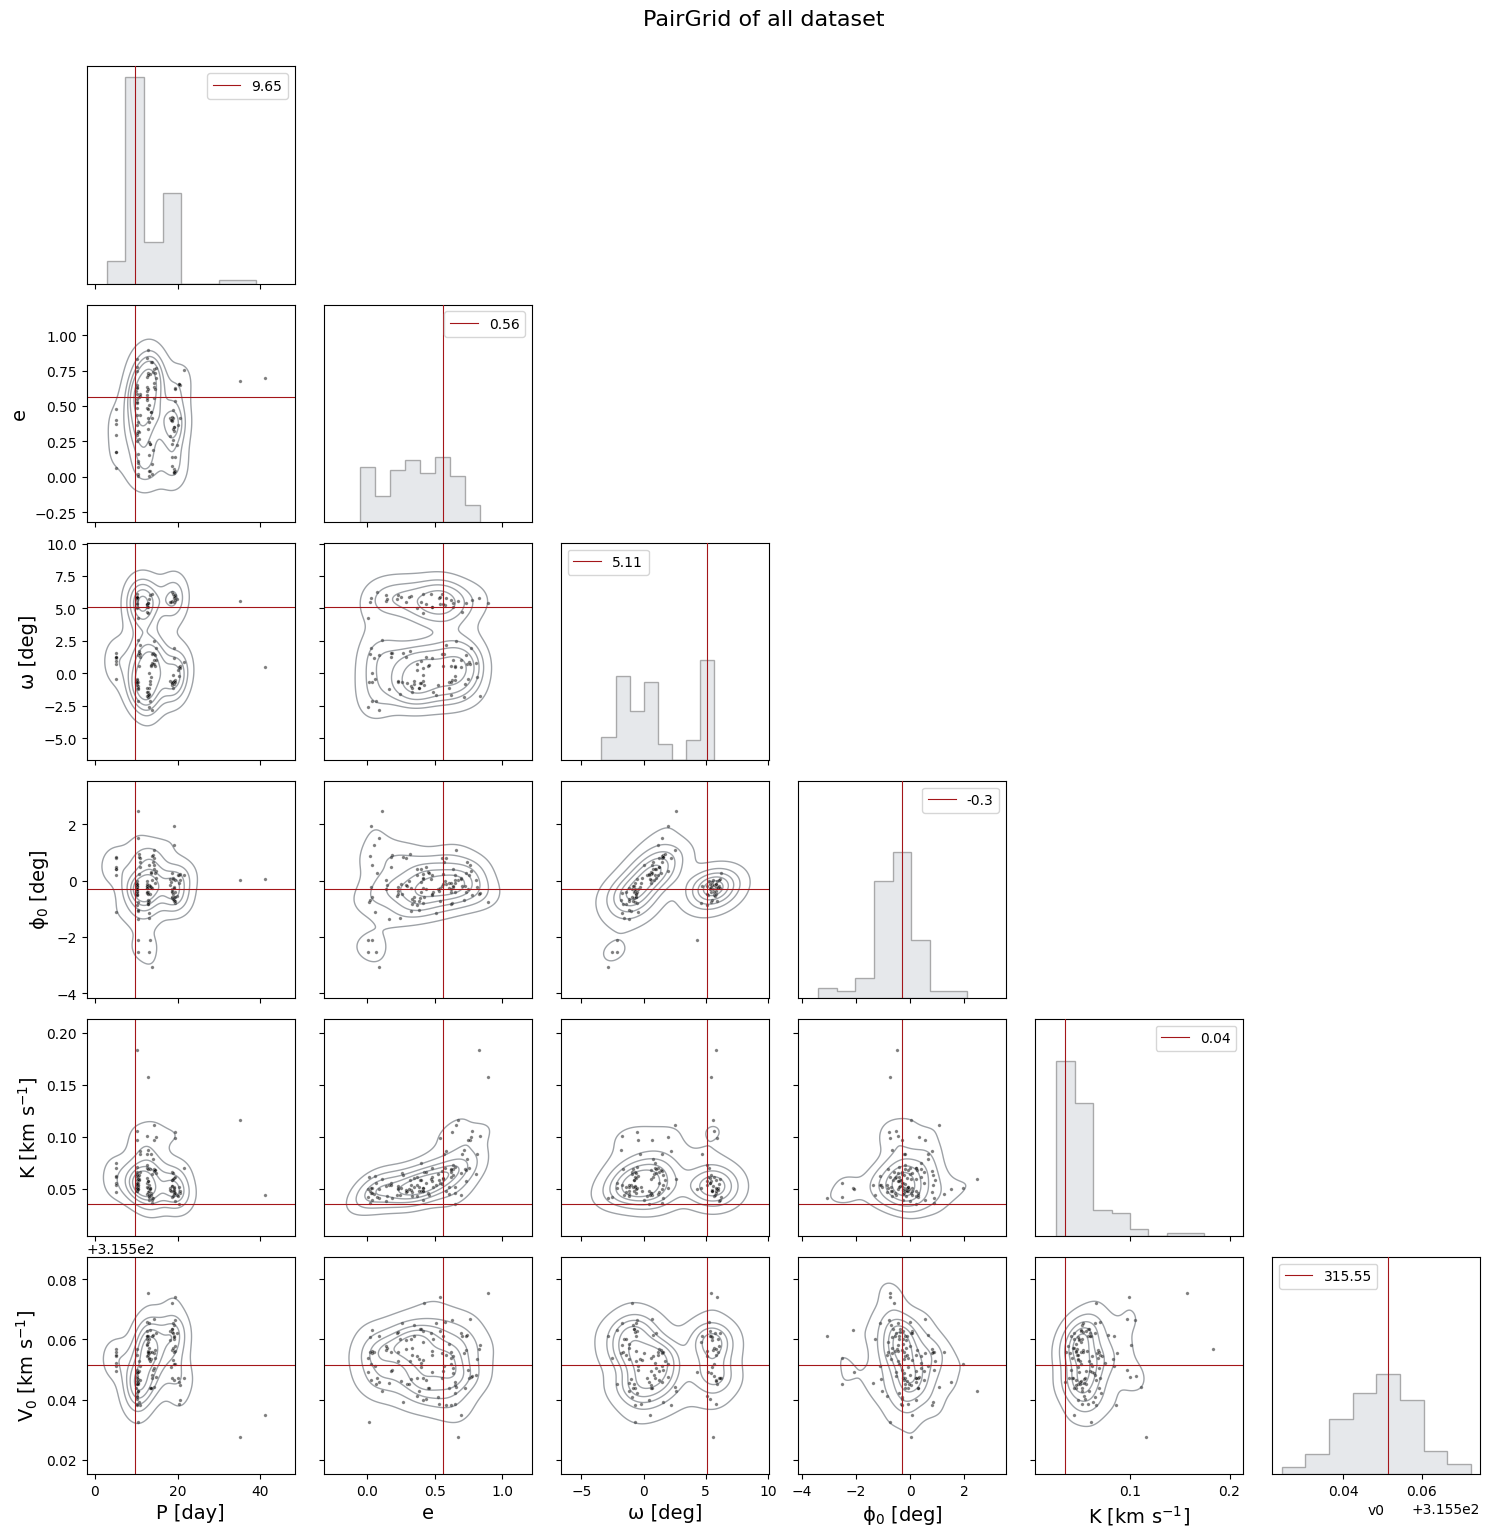

In [16]:
# Crear un gráfico de correlación utilizando pairplot
df = samples.tbl.to_pandas()
g = sns.PairGrid(df, 
            x_vars=["P", "e", "omega", "M0", "K", "v0"],
            y_vars=["P", "e", "omega", "M0", "K", "v0"],
            corner=True)                                   # No muestra las de encima de la diagonal
# Mostrar el gráfico

g.map_diag(plt.hist,  bins = "sturges", histtype='stepfilled', density = False ,alpha=0.3, align = 'left', color = '#adb5bd', ec="k")             #Histogramas en la diagonal
g.map_lower(sns.kdeplot,linewidths = 1, levels=6,  color="#3F4750",thresh=.1, alpha = 0.5)             # Muestra los contornos
g.map_lower(sns.scatterplot,s = 6, alpha = 0.5, color="k")                     # Muestra los puntos

# Añadir bordes y rejillas a cada cuadrícula
for ax in g.axes.flatten():
    if ax is not None:
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['top'].set_visible(True)
        ax.grid(False)

# Agregar líneas verticales y horizontales en los gráficos de densidad fuera de la diagonal
for i, x_var in enumerate(variables):
    for j, y_var in enumerate(variables):
        if i != j:
            ax = g.axes[j, i]
            if ax is not None:
                ax.axvline(x=picos[i], color='#a4161a', linestyle='-', linewidth=0.8)
                ax.axhline(y=picos[j], color='#a4161a', linestyle='-', linewidth=0.8)
                ax.set_xlabel(xlabel[i], fontsize = 14)
                ax.set_ylabel(xlabel[j], fontsize = 14)

# Agregar líneas verticales personalizadas en las diagonales

for i in np.arange(len(g.diag_axes)):
    ax = g.diag_axes[i]
    ax.axvline(x=picos[i], color='#a4161a', linestyle='-', linewidth = 0.8, label = f"{round(picos[i],2)}")
    ax.legend()
    
ax.set_ylabel(xlabel[-1], fontsize = 14)

# Título del PairGrid
g.fig.suptitle("PairGrid of all dataset", y=1.02, fontsize = 16)
plt.show

In [19]:
len(bins)

9

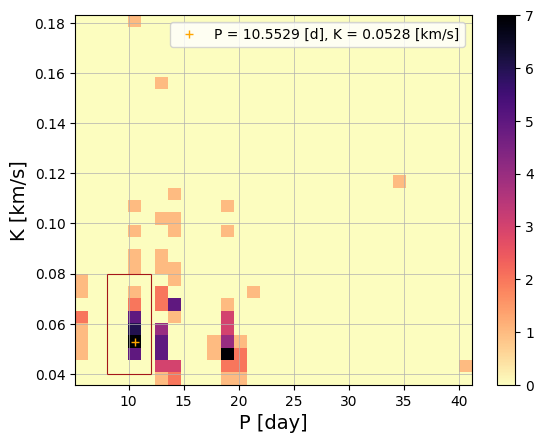

Coordenadas del valor más significativo:
x = 10.552931157281277
y = 0.05283726387904792


In [55]:
bin = 30

# Calcula el histograma bidimensional
hist, x_edges, y_edges = np.histogram2d(x=samples['P'].value, y=samples['K'].to(u.km/u.s).value, bins=bin)

# Encuentra las coordenadas del bin con el valor máximo en el histograma
max_index = np.unravel_index(np.argmax(hist), hist.shape)
x_max_density = (x_edges[max_index[0]] + x_edges[max_index[0] + 1]) / 2
y_max_density = (y_edges[max_index[1]] + y_edges[max_index[1] + 1]) / 2

# Grafica el histograma
fig, ax = plt.subplots()
h = ax.hist2d(x=samples['P'].value, y=samples['K'].to(u.km/u.s).value, bins=bin, cmap = "magma_r")
fig.colorbar(h[3], ax=ax)
ax.plot(x_max_density, y_max_density, "+", color="orange", label=f"P = {round(x_max_density, 4)} [d], K = {round(y_max_density, 4)} [km/s]")
ax.set_xlabel("P [day]", fontsize = 14)
ax.set_ylabel("K [km/s]", fontsize = 14)

xmin = 8#42-2/7*4
xmax = 12#42+2/7*7
ymin = 0.04
ymax = 0.08

ax.vlines(x=xmin, ymin = ymin, ymax = ymax, color='#a4161a', linestyle='-', linewidth=0.8)
ax.vlines(x=xmax, ymin = ymin, ymax = ymax, color='#a4161a', linestyle='-', linewidth=0.8)

ax.hlines(y=ymin ,xmin = xmin, xmax = xmax, color='#a4161a', linestyle='-', linewidth=0.8)
ax.hlines(y=ymax, xmin = xmin, xmax = xmax, color='#a4161a', linestyle='-', linewidth=0.8)

plt.grid(linestyle='-', linewidth=0.5)
plt.legend()


plt.show()

print("Coordenadas del valor más significativo:")
print("x =", x_max_density)
print("y =", y_max_density)

In [56]:
mask_P = (samples["P"].value>=xmin) & (samples["P"].value<=xmax)

Filtrado = samples[mask_P]
mask_K = (Filtrado["K"].value>=ymin) & (Filtrado["K"].value<=ymax)

Filtrado = Filtrado[mask_K]

In [57]:
Filtrado

<JokerSamples [P, e, omega, M0, s, K, v0] (26 samples)>

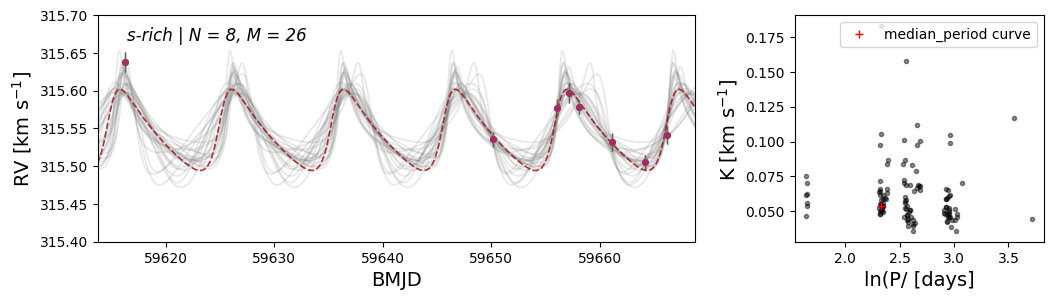

In [61]:
fig = plt.figure(figsize=(22,10))

gs = fig.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.48, wspace=0.4)
f_ax1 = fig.add_subplot(gs[-1, :-1])
f_ax2 = fig.add_subplot(gs[-1,-1])

_ = tj.plot_rv_curves(Filtrado,data=data,plot_kwargs=dict(color="tab:grey",linewidth = 1.2),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1)
_ = tj.plot_rv_curves(Filtrado.median_period(),data=data,plot_kwargs=dict(linestyle = "--", linewidth = 1.2,color="#a4161a"),data_plot_kwargs=dict(color="#A52C60"),relative_to_t_ref=False,ax=f_ax1, add_labels=True)
f_ax2.scatter(np.log(samples['P'].value), samples['K'].value,marker='.', color='k', alpha=0.45)

f_ax2.plot(np.log(Filtrado.median_period()["P"].value),Filtrado.median_period()["K"], "+", color = "red", label = 'median_period curve' )

f_ax1.set_xlabel("BMJD",fontsize=14)
f_ax1.set_ylabel("RV [km s$^{-1}]$", fontsize=14)

f_ax2.set_xlabel("ln(P/ [days]",fontsize=14)
f_ax2.set_ylabel("K [km s$^{-1}]$ ",fontsize=14)

f_ax1.set_ylim(315.4,315.7)
f_ax1.text(0.05, 0.95, f's-rich | N = {len(t)}, M = {len(Filtrado)}', transform=f_ax1.transAxes, fontsize = 12, verticalalignment='top', horizontalalignment='left', fontstyle = 'italic')
f_ax2.legend(fontsize = 10)
plt.show()

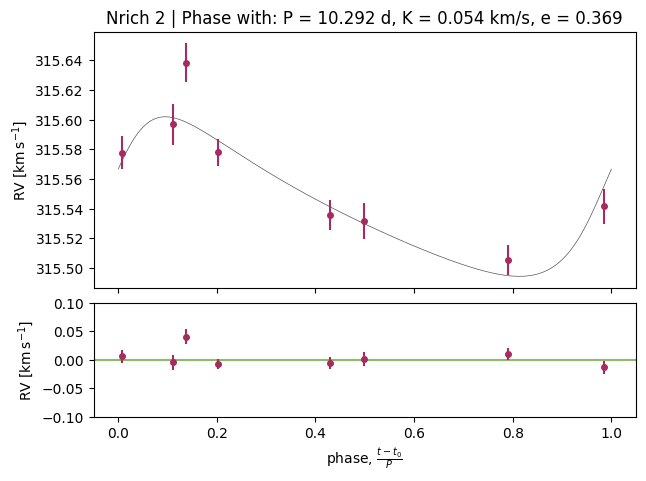

In [63]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 5), gridspec_kw={"height_ratios": (1.8, 0.8), 'hspace': 0.08})

ax[0].set_title(f"Nrich 2 | Phase with: P = {round(float(Filtrado.median_period()['P'].value),3)} d, K = {round(float(Filtrado.median_period()['K'].value),3)} km/s, e = {round(float(Filtrado.median_period()['e'].value),3)}",fontsize = 12)

    
_ = tj.plot_phase_fold(Filtrado.median_period(), data=data,ax=ax[0],remove_trend = False, data_plot_kwargs=dict(color="#A52C60"))
_ = tj.plot_phase_fold(Filtrado.median_period(), data, ax=ax[1], residual=True, data_plot_kwargs=dict(color="#A52C60"))

ax[1].axhline(0, zorder=-10, color="#73a942", alpha=0.8)
ax[1].set_ylim(-0.1, 0.1)

for ax in fig.get_axes():
    ax.label_outer()
    #ax.grid(linestyle='-', linewidth=0.1)

Las **enanas marrones** son objetos subestelares que tienen más masa que los planetas gigantes gaseosos más grandes , pero menos que las estrellas menos masivas de la secuencia principal. Su masa es aproximadamente de $13 - 80$ veces la de Júpiter ( $M_J$ ) 

In [64]:
# En nuestro caso
def Calculo_Masa(P,K,e):
    P = float(P.value)*u.day
    e = float(e.value)
    K = float(K.to("m/s").value)*u.m/u.s
    
    print("P =",P)
    print("e =",e)
    print("K =",K)
    
    def f(P,e,K):
        G = 6.67430e-11*(u.m)**3*1/u.kg * 1/u.s**2
        f = (P*K**3*(1-e**2)**(3/2))/(2*np.pi*G)
        f = f.cgs
        f = (f/(1.989e+33*u.g)*u.M_sun)
        return f
    
    # Función de masa
    f_value = f(P,e,K)
    
    
    M1 = 0.8*u.M_sun
    sini =  1
    
    # Ejemplo de uso
    def resolver_ecuacion_cubica(a, b, c, d):
        coeficientes = [a, b, c, d]
        raices = np.roots(coeficientes)
        return raices
        
    a = (sini)**3
    b = -f_value.value
    c = -2*M1.value*f_value.value
    d = -M1.value**2*f_value.value
    
    raices = resolver_ecuacion_cubica(a, b, c, d)
    print("Las raíces de la ecuación son:", raices)
    
    M2 = raices[0].real*u.M_sun
    M_jupiter = 1.898e27*u.kg
    print("La masa del objeto en M_Sun, M2 = ",M2)
    print("La masa del objeto en kg, M2 = ",M2.to("kg"))
    print("La masa del objeto en M_J, M2 = ",M2.to("M_jup"))
    print("La masa del objeto en M_E, M2 = ",M2.to("M_earth"))
    return M2

In [65]:
M2 = Calculo_Masa(Filtrado.median_period()["P"],Filtrado.median_period()["K"],Filtrado.median_period()["e"])

P = 10.29234330602662 d
e = 0.36901411757261776
K = 53.77831743226235 m / s
Las raíces de la ecuación son: [ 0.00044019+0.j         -0.0002201 +0.00038094j -0.0002201 -0.00038094j]
La masa del objeto en M_Sun, M2 =  0.000440192660563039 solMass
La masa del objeto en kg, M2 =  8.752834312723835e+26 kg
La masa del objeto en M_J, M2 =  0.4611306510124847 jupiterMass
La masa del objeto en M_E, M2 =  146.5604200432631 earthMass


In [66]:
def f(P,e,K):
        G = 6.67430e-11*(u.m)**3*1/u.kg * 1/u.s**2
        f = (P*K**3*(1-e**2)**(3/2))/(2*np.pi*G)
        f = f.cgs
        f = (f/(1.989e+33*u.g)*u.M_sun)
        return f
M1 = 0.8*u.M_sun
sini =  1

In [67]:
def resolver_ecuacion_cubica(a, b, c, d):
        coeficientes = [a, b, c, d]
        raices = np.roots(coeficientes)
        return raices

In [68]:
P_all = Filtrado["P"]
e_all = Filtrado["e"]
K_all = Filtrado["K"].to(u.m/u.s)

# Función de masa
f_value_all = f(P_all,e_all,K_all)
f_value_all

<Quantity [1.43490536e-10, 1.34247768e-10, 7.52743339e-11, 2.51487910e-10,
           1.68904736e-10, 1.32864564e-10, 1.03272001e-10, 2.19614790e-10,
           1.76767864e-10, 1.87561360e-10, 2.38386883e-10, 1.27215379e-10,
           1.24178464e-10, 1.65307328e-10, 6.31422660e-11, 2.56270146e-10,
           1.70612480e-10, 1.03023465e-10, 1.44333780e-10, 1.18979916e-10,
           1.91680152e-10, 1.15924198e-10, 1.33128370e-10, 1.27505893e-10,
           1.30296529e-10, 1.32551260e-10] solMass>

In [69]:
a_all = [(sini)**3]*len(f_value_all.value)
b_all = -f_value_all.value
c_all = -2*M1.value*f_value_all.value
d_all = -M1.value**2*f_value_all.value

raices_all = []
M2_all = []
for i in np.arange(len(f_value_all)):
    raices_all = (resolver_ecuacion_cubica(a_all[i], b_all[i], c_all[i], d_all[i]))
    M2_all.append(((raices_all[0].real*u.M_sun).value))

In [70]:

P_all_full = samples["P"]
e_all_full = samples["e"]
K_all_full = samples["K"].to(u.m/u.s)

# Función de masa
f_value_all_full = f(P_all_full,e_all_full,K_all_full)
f_value_all_full

<Quantity [1.43490536e-10, 1.34247768e-10, 1.64935394e-10, 7.52743339e-11,
           3.03282336e-10, 9.89344816e-11, 1.70631996e-10, 2.82875658e-10,
           3.67374047e-10, 2.51487910e-10, 1.88512577e-10, 8.71973216e-10,
           2.26115456e-10, 2.19715264e-10, 1.00876990e-10, 9.80705454e-11,
           4.18893620e-10, 2.66429076e-10, 1.62922109e-10, 1.68904736e-10,
           1.32864564e-10, 1.03272001e-10, 2.73614973e-10, 1.25514356e-10,
           2.19614790e-10, 3.00293986e-10, 1.96530214e-10, 3.74205426e-10,
           1.92794903e-10, 4.01878793e-10, 2.49172065e-10, 3.19753421e-10,
           1.15607726e-10, 2.30759032e-10, 1.87682815e-10, 4.74687831e-11,
           1.32269912e-10, 1.08645051e-10, 1.82072156e-10, 8.48541646e-11,
           1.09531744e-09, 2.31788020e-09, 4.87067636e-10, 1.76767864e-10,
           1.87561360e-10, 2.89919302e-10, 1.19913337e-10, 2.38386883e-10,
           1.99460932e-10, 1.36770446e-10, 6.30856149e-11, 3.63549677e-10,
           1.27215379e-10

In [71]:
a_all_full = [(sini)**3]*len(f_value_all_full.value)
b_all_full = -f_value_all_full.value
c_all_full = -2*M1.value*f_value_all_full.value
d_all_full = -M1.value**2*f_value_all_full.value

raices_all_full = []
M2_all_full = []
for i in np.arange(len(f_value_all_full)):
    raices_all_full = (resolver_ecuacion_cubica(a_all_full[i], b_all_full[i], c_all_full[i], d_all_full[i]))
    M2_all_full.append(((raices_all_full[0].real*u.M_sun).value))

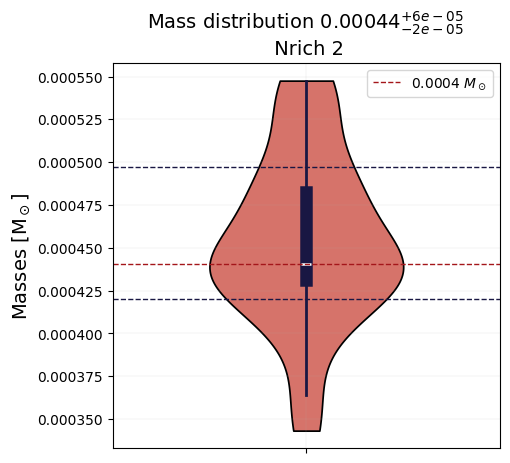

In [74]:
plt.figure(figsize=(5,5))


sns.violinplot(y = abs(np.array(M2_all)),inner_kws=dict(box_width=9, whis_width=2, color="#191743"),
               color = "#e3685c",saturation=0.8, fill=True, inner='box', split=False, width=0.5,
               dodge='auto', gap=0,density_norm='area',common_norm=False, bw_adjust=0.85,
              linecolor='k', cut=0, gridsize=250, native_scale=False)

# Calcula la densidad de la distribución
density = gaussian_kde(M2_all)

# Encuentra el rango de valores en el eje y
y_values = np.linspace(min(M2_all), max(M2_all), 1000)

# Evalúa la densidad en el rango de valores en el eje y
density_values = density(y_values)

# Encuentra el índice del máximo valor de densidad
peak_index = np.argmax(density_values)

# Encuentra el valor en el eje y correspondiente al pico
peak_value = y_values[peak_index]
percentile_16_mass = np.percentile(np.array(M2_all), 16)
percentile_84_mass = np.percentile(np.array(M2_all), 84)

# Calcular el error estimado (asimétrico)
error_lower_mass = (peak_value - percentile_16_mass)
error_upper_mass = (percentile_84_mass - peak_value)

#print("El pico más alto de la distribución está en:", peak_value)

#plt.axhline(y=M2.value, color='#D0D3D4', linestyle='--',linewidth = 1, label = f'$M_2$ = { round(float(M2.value),3)} $M_\odot$')
plt.axhline(y=peak_value, color='#a4161a', linestyle='--',linewidth = 1, label = f'{ round(peak_value,4)} $M_\odot$')
plt.axhline(peak_value-abs(error_lower_mass), color='#191743', linestyle='dashed', linewidth=1)
plt.axhline(peak_value+abs(error_upper_mass), color='#191743', linestyle='dashed', linewidth=1)

plt.ylabel("Masses [M$_\odot$]", fontsize = 14)
plt.title("Mass distribution"+f" ${round(peak_value,5)}^{{+{round(abs(error_upper_mass),5)}}}_{{-{round(abs(error_lower_mass),5)}}}$ \n Nrich 2", fontsize = 14)
plt.legend()
plt.grid(linestyle='-', linewidth=0.1)
plt.show()

In [75]:
Mc = peak_value*u.M_sun.to("M_jup")
Mme = error_upper_mass*u.M_sun.to("M_jup")
Mma = error_lower_mass*u.M_sun.to("M_jup")

print(f"Mass distribution {round(Mc,4)}^{{+{round(abs(Mme),4)}}}_{{-{round(abs(Mma),4)}}} \n")

Mass distribution 0.4618^{+0.0589}_{-0.0215} 



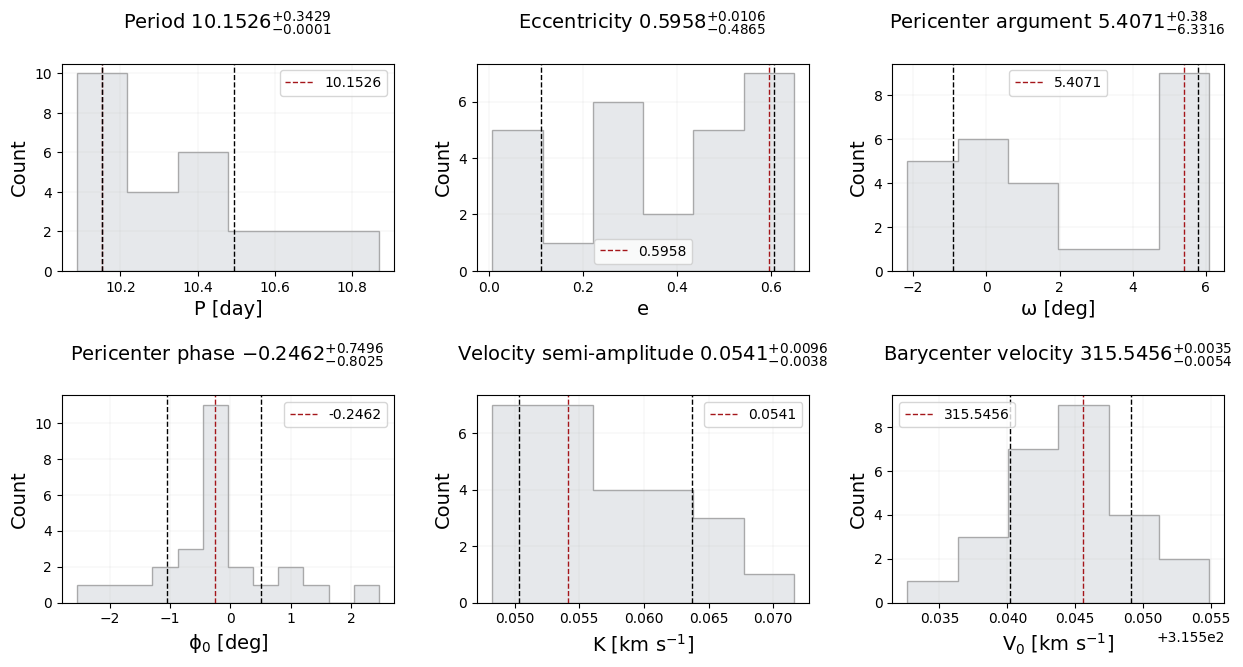

In [76]:
variables = ["P", "e", "omega", "M0", "K", "v0"]
xlabel = ["P [day]", "e", "ω [deg]", "ϕ$_0$ [deg]", "K [km s$^{-1}$]","V$_0$ [km s$^{-1}$]"]
title = ["Period","Eccentricity", "Pericenter argument", "Pericenter phase", "Velocity semi-amplitude", "Barycenter velocity"]
picos = []


fig = plt.figure(figsize=(15,7))

gs = fig.add_gridspec(2, 3, hspace=0.6, wspace=0.25)
(ax1,ax2,ax3), (ax4,ax5,ax6) = gs.subplots(sharey = False, sharex = False)

for ax,i in zip(fig.get_axes(),np.arange(len(variables))):
    ax.set_ylabel("Count", fontsize = 14)
    ax.set_xlabel(xlabel[i], fontsize = 14)
    conteos, bins, _  =  ax.hist(Filtrado[variables[i]], bins = "auto", histtype='stepfilled', density = False ,alpha=0.3, align = 'mid', color = '#adb5bd', ec="k")
    # indice_maximo = np.argmax(conteos)
    # # Obtener el valor del pico más alto
    # pico_mas_alto = bins[indice_maximo]
    # picos.append(pico_mas_alto)
    # Calcular percentiles
    # Calcular el histograma y encontrar el pico (máximo de densidad)
    hist, bin_edges = np.histogram(Filtrado[variables[i]].value, bins="auto", density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    peak_index = np.argmax(hist)
    peak_value = bin_centers[peak_index]

    percentile_16 = np.percentile(Filtrado[variables[i]].value, 16)
    percentile_84 = np.percentile(Filtrado[variables[i]].value, 84)
    
    # Calcular el error estimado (asimétrico)
    error_lower = (peak_value - percentile_16)
    error_upper = (percentile_84 - peak_value)
    
    ax.set_title(title[i]+f" ${round(peak_value,4)}^{{+{round(abs(error_upper),4)}}}_{{-{round(abs(error_lower),4)}}}$ \n", fontsize = 14)

    # Agregar una línea vertical en el pico más alto
    #ax.axvline(x=pico_mas_alto, color='#a4161a', linestyle='--', linewidth = 1, label = f"{round(pico_mas_alto,2)}")
    ax.axvline(peak_value, color='#a4161a', linestyle='dashed', linewidth=1,label = f"{round(peak_value,4)}")
    ax.axvline(peak_value-abs(error_lower), color='k', linestyle='dashed', linewidth=1)
    ax.axvline(peak_value+abs(error_upper), color='k', linestyle='dashed', linewidth=1)
    ax.grid(linestyle='-', linewidth=0.1)
    ax.legend()

### Estimación de la masa

In [134]:
B = 12.360 
V = 11.400
B_V = B-V
B_V

0.9599999999999991

#### Magnitud absoluta:

$$M = m - 5(log_{10}(d_{pc})-1)$$

In [135]:
m_V = V
d = np.mean([1293.810,1406.272,1307.8734,1138.96]) # Distancias encontradas en Simbad en pc
M=m_V-5*(np.log10(d)-1)
M

0.8525648076515715

#### Luminosidad

$$M = M_{\odot} - 2.5 \log_{10}\left(\frac{L}{L_{\odot}}\right)$$

$$L = 10^{-\frac{M-M_\odot}{2.5}}L_{\odot}$$

In [136]:
L=10**(-(M-4.83)/2.5)
L

38.9918711713353

In [137]:
masa = L**(1/3)
masa

3.3909758148752305